In [2]:
FIGURES_PATH = 'out/figures/'
DATASETS_PATH = 'out/datasets/'

In [3]:
import pandas as pd
from datetime import datetime
import os
import multiprocessing
import numpy as np
import matplotlib.pyplot as plt
from pandarallel import pandarallel
import psutil
import matplotlib.colors as mcolors
import random
from tqdm import tqdm

from helper import *

In [4]:
NROWS = None

In [5]:
data = pd.read_csv(DATASETS_PATH + 'data_processed.csv', nrows=NROWS).drop(columns=['Unnamed: 0'])
data['datetime'] = pd.to_datetime(data['datetime'])
data

,gid,transaction_key,store_id,product_id,line_item_price,line_item_cost,line_type,datetime,category_id,weekday,line_quantity
0,0,0,2,0,2990.0,2516.10,0,2022-04-18 12:22:18,49788.0,0,1.0
1,1,1,3,1,1413.0,1206.73,1,2022-08-26 18:00:29,140669.0,4,2.0
2,1,1,3,2,338.0,179.51,1,2022-08-26 18:00:29,157827.0,4,4.0
3,1,1,3,3,1634.0,1402.83,1,2022-08-26 18:00:29,NaN,4,1.0
4,1,1,3,4,78.0,61.70,1,2022-08-26 18:00:29,484922.0,4,40.0
...,...,...,...,...,...,...,...,...,...,...,...
20662670,861563,3945281,2,70820,1925.0,1469.14,0,2022-09-08 11:14:12,381032.0,3,1.0
20662671,861563,3945281,2,3161,43.0,44.66,0,2022-09-08 11:14:12,33888.0,3,22.0
20662672,861563,3945281,2,2612,950.0,969.86,0,2022-09-08 11:14:12,13517.0,3,1.0
20662673,861563,3945281,2,51,4.0,NaN,0,2022-09-08 11:14:12,NaN,3,1.0


### Функции вывода графиков

In [6]:
def scatter_prices(data, line_article_id):
    these_prices = data.loc[data['product_id'] == line_article_id][['line_item_price', 'datetime', 'line_quantity']]
    grouped_prices = these_prices.groupby(['line_item_price'])
    ans = grouped_prices['line_quantity'].apply(lambda x: x.sum())

    ans_cnt = grouped_prices['line_quantity'].apply(lambda x: len(x))
    cnt = (ans_cnt.array - ans_cnt.array.min()) / (ans_cnt.array.max() - ans_cnt.array.min())
    cnt *= 50

    prices, counts = ans.axes, ans.array

    fig1, ax1 = plt.subplots(figsize=(20, 10))
    fig2, ax2 = plt.subplots(figsize=(20, 10))

    fig1.suptitle('Items')
    fig2.suptitle('Buyers')

    ax1.set_xlabel("Price, RUR")
    ax1.set_ylabel("Count of items")
    ax1.grid(axis='x', which='major')

    ax1.set_title(
        str(line_article_id) + ' - ' + str(these_prices['line_quantity'].sum()))
    ax1.scatter(prices[0], counts, s=cnt, c=counts, cmap='cool')

    ax2.set_xlabel("Price, RUR")
    ax2.set_ylabel("Count of buyers")
    ax2.grid(axis='x', which='major')

    ax2.set_title(
        str(line_article_id) + ' - ' + str(these_prices['line_quantity'].sum()))
    ax2.scatter(prices[0], cnt, s=cnt, c=counts, cmap='cool')


    # plot = ax2.pcolor(counts)
    # fig2.colorbar(plot)

# scatter_prices(data, 15058563)


In [7]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

DATASETS_PATH = 'out/datasets/'

def compute_elasticity(x):
    # Рассчитываем изменение спроса и изменение цены
    prices = x.index.values
    quantities = x.values
    delta_q, delta_p = [], []
    for i in range(1, len(quantities)):
        delta_q.append(quantities[i] / quantities[i - 1] - 1)
        delta_p.append(prices[i] / prices[i - 1] - 1)

    # Рассчитываем процентное изменение спроса и процентное изменение цены
    # percent_delta_q = delta_q / quantities[:-1] * 100
    # percent_delta_p = delta_p / prices[:-1] * 100

    # Рассчитываем ценовую эластичность спроса
    elasticity = np.array(delta_q) / np.array(delta_p)

    plt.plot(prices[1:], elasticity)
    plt.xlabel('Цена, руб')
    plt.ylabel('Эластичность спроса')
    plt.title('График эластичности спроса по цене')
    plt.show()

    return elasticity

def get_prices_quantities(data):
    return data.groupby(by=['product_id', 'line_item_price'])['line_quantity'].sum()

In [8]:
data = pd.read_csv(DATASETS_PATH + 'data_processed.csv', nrows=500_000).drop(columns=['Unnamed: 0'])
data['datetime'] = pd.to_datetime(data['datetime'])

In [9]:
# pq = get_prices_quantities(data)
# ans = dict()
# for ind in pq.index:
#     prod = ind[0]
#     price = ind[1]
#     if prod in ans:
#         ans[prod] += 1
#     else:
#         ans[prod] = 1
#
# ans = sorted(ans.items(), key=(lambda x: x[1]))
# ans[-5]

NameError: name 'pq' is not defined

In [ ]:

# print(pq[1].index.values)
compute_elasticity(pq[56])

In [40]:
def scatter_mean_prices(data, ylim=None):
    fig, ax = plt.subplots(figsize=(20, 10))

    ax.scatter(data.index, data['average_price'], s=0.2)

    x = data['average_price']
    m, s = x.mean(), x.std()

    ax.axhline(m - s, alpha=0.5, linestyle='--', color='r', label='σ')
    ax.axhline(m + s, alpha=0.5, linestyle='--', color='r')
    ax.axhline(m, alpha=0.5, linestyle='--', color='g', label='mean')

    ax.set_ylim(bottom=0, top=ylim)
    ax.set_xlim(left=0)
    ax.set_xlabel('Users')
    ax.set_ylabel('Mean price')
    ax.set_title('Mean prices')

    ax.legend()
    plt.savefig(FIGURES_PATH + 'users_mean_prices')

In [41]:
def scatter_hist_of_prices(data, nbins=10, price_limit=None):
    fig, ax = plt.subplots(figsize=(20, 10))
    x = data['average_price'].values
    m, s = x.mean(), x.std()


    ax.hist(x, bins=nbins, range=price_limit, histtype='bar', edgecolor='black', linewidth=1.1)
    ax.axvline(m - s, alpha=0.5, linestyle='--', color='r', label='σ')
    ax.axvline(m + s, alpha=0.5, linestyle='--', color='r')

    ax.axvline(m, alpha=0.5, linestyle='--', color='g', label='mean')

    ax.set_xlabel('Средняя цена в чеке')
    ax.set_ylabel('Количество покупателей')
    ax.set_title('Гистограмма количества покупателей по средней цене в чеке')
    ax.legend()
    plt.savefig(FIGURES_PATH + 'users_hist')

In [42]:
def scatter_hist_of_products(data, nbins=10, price_limit=None):
    fig, ax = plt.subplots(figsize=(20, 10))
    x = data['line_item_price'].values

    m, s = x.mean(), x.std()
    ax.hist(x, bins=nbins, range=price_limit, histtype='bar', edgecolor='black', linewidth=1.1)

    ax.axvline(m - s, alpha=0.5, linestyle='--', color='r', label='σ')
    ax.axvline(m + s, alpha=0.5, linestyle='--', color='r')
    ax.axvline(m, alpha=0.5, linestyle='--', color='g', label='mean')

    ax.set_xlabel('Цена товара')
    ax.set_ylabel('Количество товаров')
    ax.set_title('Гистограмма количества товаров по средней цене')

    ax.legend()
    plt.savefig(FIGURES_PATH + 'products_hist')

In [48]:
def scatter_hist_of_weekdays(data):
    fig, ax = plt.subplots(figsize=(10, 10))
    x = data['weekday'].values

    ax.hist(x, bins=7, histtype='bar', edgecolor='black', linewidth=1.1)

    ax.set_xlabel('День недели')
    ax.set_ylabel('Количество покупок')
    ax.set_title('Гистограмма количества покупок по дням недели')
    ax.set_xticks([i for i in range(0, 7)], ['Воскресенье', 'Понедельник', 'Вторник', 'Среда', 'Четверг', 'Пятница', 'Суббота'], rotation=45)

    ax.legend()
    plt.savefig(FIGURES_PATH + 'weekdays_hist')

In [44]:
def scatter_pie_of_prices(data, nbins=5, top_limit=10_000):
    fig, ax = plt.subplots(figsize=(10, 10))
    x, bin_edges = np.histogram(data['line_item_price'].values, bins=nbins, range=(0, top_limit))
    colors = plt.get_cmap('Blues')(np.linspace(0.2, 0.7, len(x)))
    ax.pie(x, colors=colors, radius=2, center=(4, 4), labels=['< ' + str(round(i)) + ' RUB' for i in bin_edges[1:]],
       wedgeprops={"linewidth": 1, "edgecolor": "white"}, autopct='%1.1f%%')


    plt.savefig(FIGURES_PATH + 'pie_of_prices')

In [45]:
def plot_over_time(data):
    plt.figure(figsize=(20, 10))
    plt.xlabel('Date')
    plt.ylabel('Count of products')
    plt.title('Product sales')

    dates = data['datetime'].dt.date.value_counts()
    dates_ma = dates.rolling(5).mean()
    dates_ma.plot(alpha=0.3, color='r')

    dates.plot()
    plt.savefig(FIGURES_PATH + 'plot_over_time')

In [46]:
def scatter_hist_over_time(data, nbins=None, plot_ma=False):
    plt.figure(figsize=(20, 10))
    plt.xlabel('Дата')
    plt.ylabel('Количество товаров')
    plt.title('Гистограмма количества проданных товаров по дате')

    dates = data['datetime'].dt.date

    mi, ma = dates.min(), dates.max()

    opti_bins = (ma - mi).days
    if nbins is None:
        nbins = opti_bins
    dates.hist(bins=nbins, histtype='bar', edgecolor='black', linewidth=1.1)

    if plot_ma:
        ma = dates.value_counts().rolling(20).mean()
        ma.plot(color='r', alpha=0.4)


    plt.savefig(FIGURES_PATH + 'hist_over_time')



### Анализ

In [18]:
def three_sigmas(ser):
    mean = ser.mean()
    std = ser.std()

    one_sigma = ser.loc[ser > mean - std].loc[ser < mean + std].shape[0] / ser.shape[0]
    two_sigma = ser.loc[ser > mean - 2 * std].loc[ser < mean + 2 * std].shape[0] / ser.shape[0]
    three_sigma = ser.loc[ser > mean - 3 * std].loc[ser < mean + 3 * std].shape[0] / ser.shape[0]
    return one_sigma, two_sigma, three_sigma

In [19]:
pandarallel.initialize(progress_bar=False, use_memory_fs=True, nb_workers=psutil.cpu_count(logical=False))

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [20]:
def get_date_info(data):
    data = data[['product_id', 'gid', 'datetime', 'weekday', 'line_item_price']]
    grouped_by_date = data.groupby(by='datetime')

    ans = grouped_by_date[['product_id']].apply(lambda x: x.nunique()).rename(columns={'product_id': 'unique_products'})

    ans['unique_users'] = grouped_by_date['gid'].apply(lambda x: x.nunique())

    ans['average_price'] = grouped_by_date['line_item_price'].apply(lambda x: np.mean(x.values))
    ans['median_price'] = grouped_by_date['line_item_price'].apply(lambda x: get_median(x))
    ans['average_quantity'] = grouped_by_date['line_quantity'].apply(lambda x: np.mean(x.values))
    ans['average_date_delta'] = grouped_by_date['datetime'].apply(lambda x: get_mean(get_time_delta(x)))

    return ans

In [21]:
# date_info = get_date_info(data)
# date_info

In [22]:
def get_weekday_info(data):
    grouped_by_weekday = data.groupby(by='weekday')
    ans = grouped_by_weekday[['transaction_key']].parallel_apply(lambda x: x.nunique()).rename(columns={'transaction_key': 'unique_receipts'})

    ans['average_receipt_sum'] = grouped_by_weekday[['line_item_price']].parallel_apply(lambda x: x.values.sum() / x.values.shape[0])
    ans['quartile_range'] = grouped_by_weekday['line_item_price'].quantile(0.75) - grouped_by_weekday['line_item_price'].quantile(0.25)
    ans['std'] = grouped_by_weekday['line_item_price'].std()
    ans['unique_users'] = grouped_by_weekday[['gid']].parallel_apply(lambda x: x.nunique())
    return ans
    #
    # return ans

In [23]:
weekday_info = get_weekday_info(data)
weekday_info

,unique_receipts,average_receipt_sum,quartile_range,std,unique_users
weekday,,,,,
0,11847,603.439138,368.0,2153.870281,11365
1,12949,606.233717,372.0,2023.691409,12383
2,13006,591.466990,370.0,1726.690787,12431
3,13222,594.775291,364.0,1935.116883,12601
4,13669,603.186392,375.0,1875.956225,13090
5,16280,622.323132,379.0,1843.806520,15580
6,14714,598.110965,375.0,2275.114711,14103


In [24]:
weekday_info.apply(three_sigmas)

,unique_receipts,average_receipt_sum,quartile_range,std,unique_users
0,0.714286,0.714286,0.714286,0.714286,0.714286
1,1.000000,1.000000,1.000000,1.000000,1.000000
2,1.000000,1.000000,1.000000,1.000000,1.000000


In [25]:
# from helper import get_median

def get_product_info(data):
    data = data[['product_id', 'line_item_price', 'store_id', 'line_item_cost', 'datetime', 'line_quantity', 'gid']]
    grouped_by_product = data.groupby(by='product_id')

    ans = grouped_by_product[['gid']].parallel_apply(lambda x: x.nunique()).rename(columns={'gid': 'unique_users'})

    ans['average_price'] = grouped_by_product[['line_item_price']].parallel_apply(lambda x: np.mean(x.values))
    ans['median_price'] = grouped_by_product[['line_item_price']].parallel_apply(lambda x: get_median(x['line_item_price']))
    ans['average_quantity'] = grouped_by_product[['line_quantity']].parallel_apply(lambda x: np.mean(x.values))
    # ans['average_date_delta'] = grouped_by_product[['datetime']].parallel_apply(lambda x: get_mean(get_time_delta(x)))
    ans['quartile_range'] = grouped_by_product['line_item_price'].quantile(0.75) - grouped_by_product['line_item_price'].quantile(0.25)
    ans['std'] = grouped_by_product['line_item_price'].std()
    return ans


In [26]:
product_info = get_product_info(data)
product_info

,unique_users,average_price,median_price,average_quantity,quartile_range,std
product_id,,,,,,
0,8,2990.000000,2990.0,1.000000,0.0,0.000000
1,190,1439.481675,1458.0,2.303665,58.0,47.702129
2,3,338.000000,338.0,3.000000,0.0,0.000000
3,127,1798.007752,1787.0,1.511628,128.0,91.524544
4,9,78.000000,78.0,14.000000,0.0,0.000000
...,...,...,...,...,...,...
56592,1,27990.000000,27990.0,1.000000,0.0,NaN
56593,1,926.000000,926.0,1.000000,0.0,NaN
56594,1,130.000000,130.0,2.000000,0.0,NaN


In [27]:
product_info.apply(three_sigmas)

,unique_users,average_price,median_price,average_quantity,quartile_range,std
0,0.987367,0.936710,0.936180,0.989770,0.981094,0.684913
1,0.995777,0.970299,0.969786,0.997067,0.991855,0.690690
2,0.997986,0.982897,0.982596,0.998710,0.996060,0.692051


In [28]:
del product_info

In [29]:
def get_user_info(data):
    """
    :param data: receipts - pandas.DataFrame
    :return: ans: info for every user - pandas.DataFrame
    """

    grouped_by_user = data[['gid', 'line_item_price', 'product_id']].groupby(by='gid')
    ans = grouped_by_user[['product_id']].apply(lambda x: x.nunique()).rename(columns={'product_id': 'unique_products'})
    ans['average_price'] = grouped_by_user[['line_item_price']].apply(lambda x: np.mean(x.values))
    ans['median_price'] = grouped_by_user[['line_item_price']].apply(lambda x: get_median(x['line_item_price']))
    ans['quartile_range'] = grouped_by_user['line_item_price'].quantile(0.75) - grouped_by_user['line_item_price'].quantile(0.25)
    ans['std'] = grouped_by_user['line_item_price'].std()
    # ans['average_date_delta'] = grouped_by_user['datetime'].apply(lambda x: get_mean(get_time_delta(x)))
    # ans['date_quartile_range'] = grouped_by_user['datetime'].apply(lambda x: get_quartile_range(get_time_delta(x)))
    return ans



In [30]:
user_info = get_user_info(data)
user_info

,unique_products,average_price,median_price,quartile_range,std
gid,,,,,
0,1,2990.000000,2990.0,0.00,NaN
1,46,470.278261,175.5,415.25,815.889769
2,1,941.000000,941.0,0.00,NaN
3,1,850.000000,850.0,0.00,NaN
4,4,876.750000,369.5,771.25,1202.269070
...,...,...,...,...,...
81593,8,147.375000,81.5,118.25,175.215734
81594,1,128.000000,128.0,0.00,NaN
81595,2,1707.000000,1707.0,1608.00,2274.055408


In [31]:
user_info.apply(three_sigmas)

,unique_products,average_price,median_price,quartile_range,std
0,0.879335,0.953945,0.956984,0.944484,0.761636
1,0.954729,0.978676,0.979252,0.974644,0.788328
2,0.980588,0.987769,0.987806,0.985147,0.797434


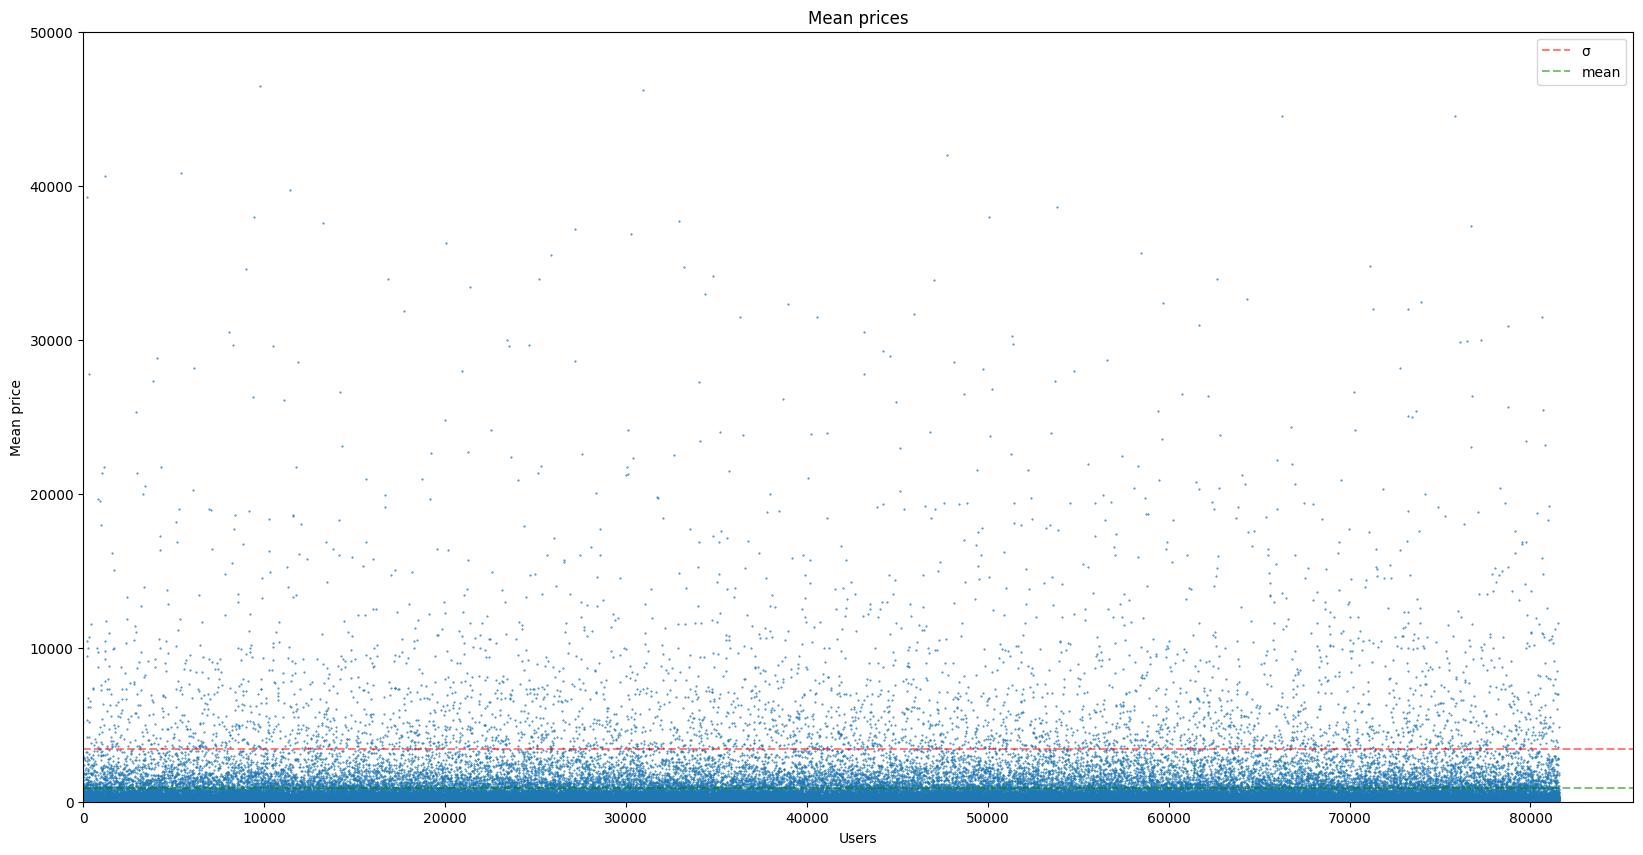

In [32]:
scatter_mean_prices(user_info, ylim=50_000)

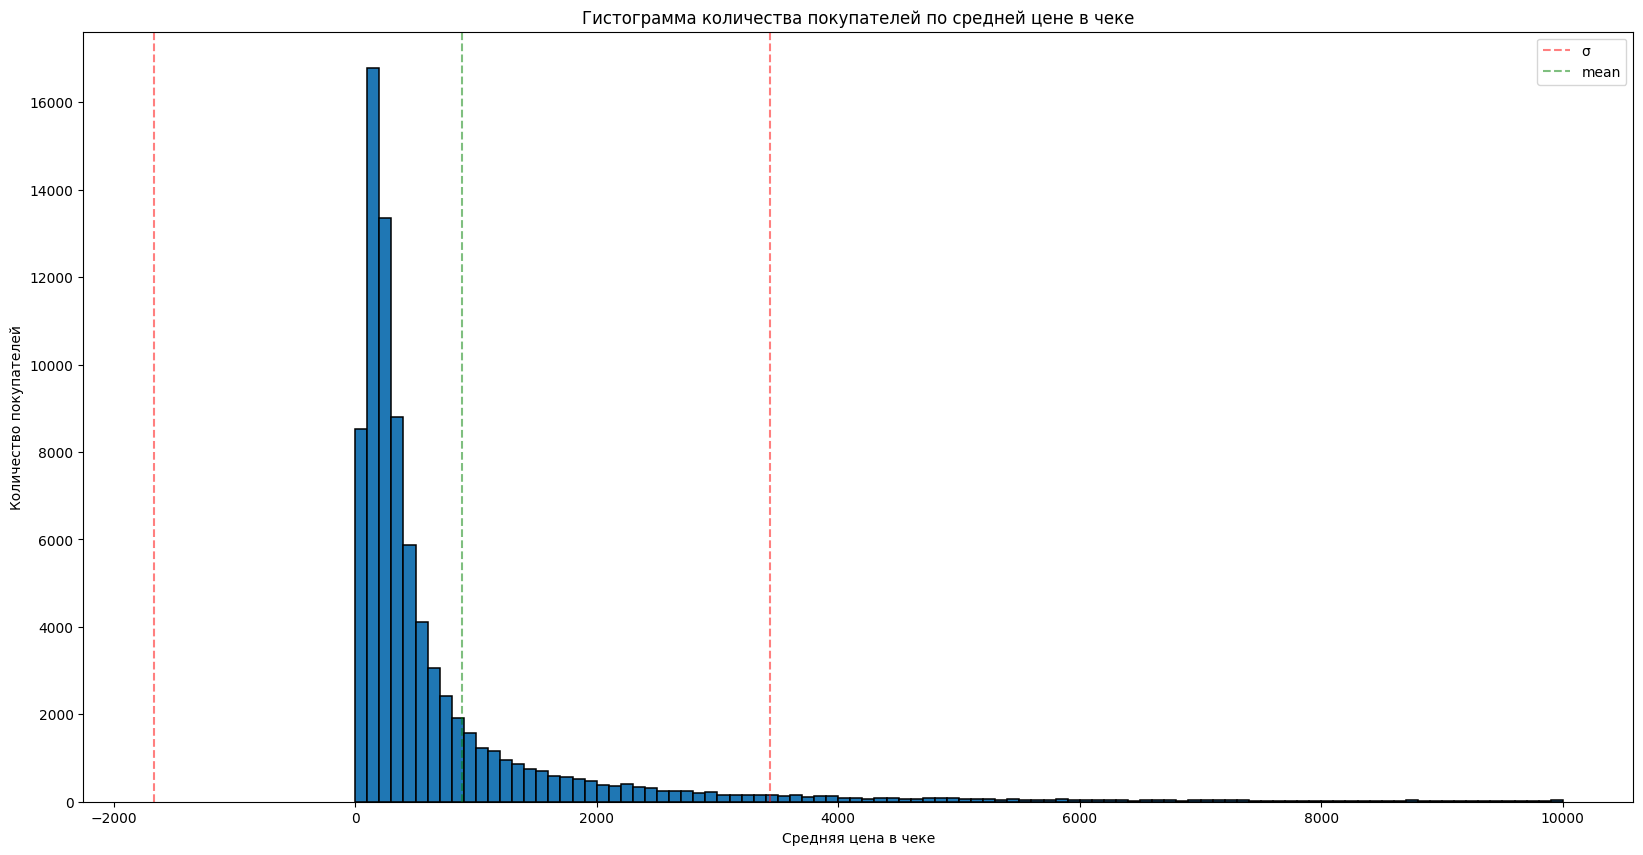

In [33]:
scatter_hist_of_prices(user_info, nbins=100, price_limit=(0, 10_000))

In [34]:
# del user_info

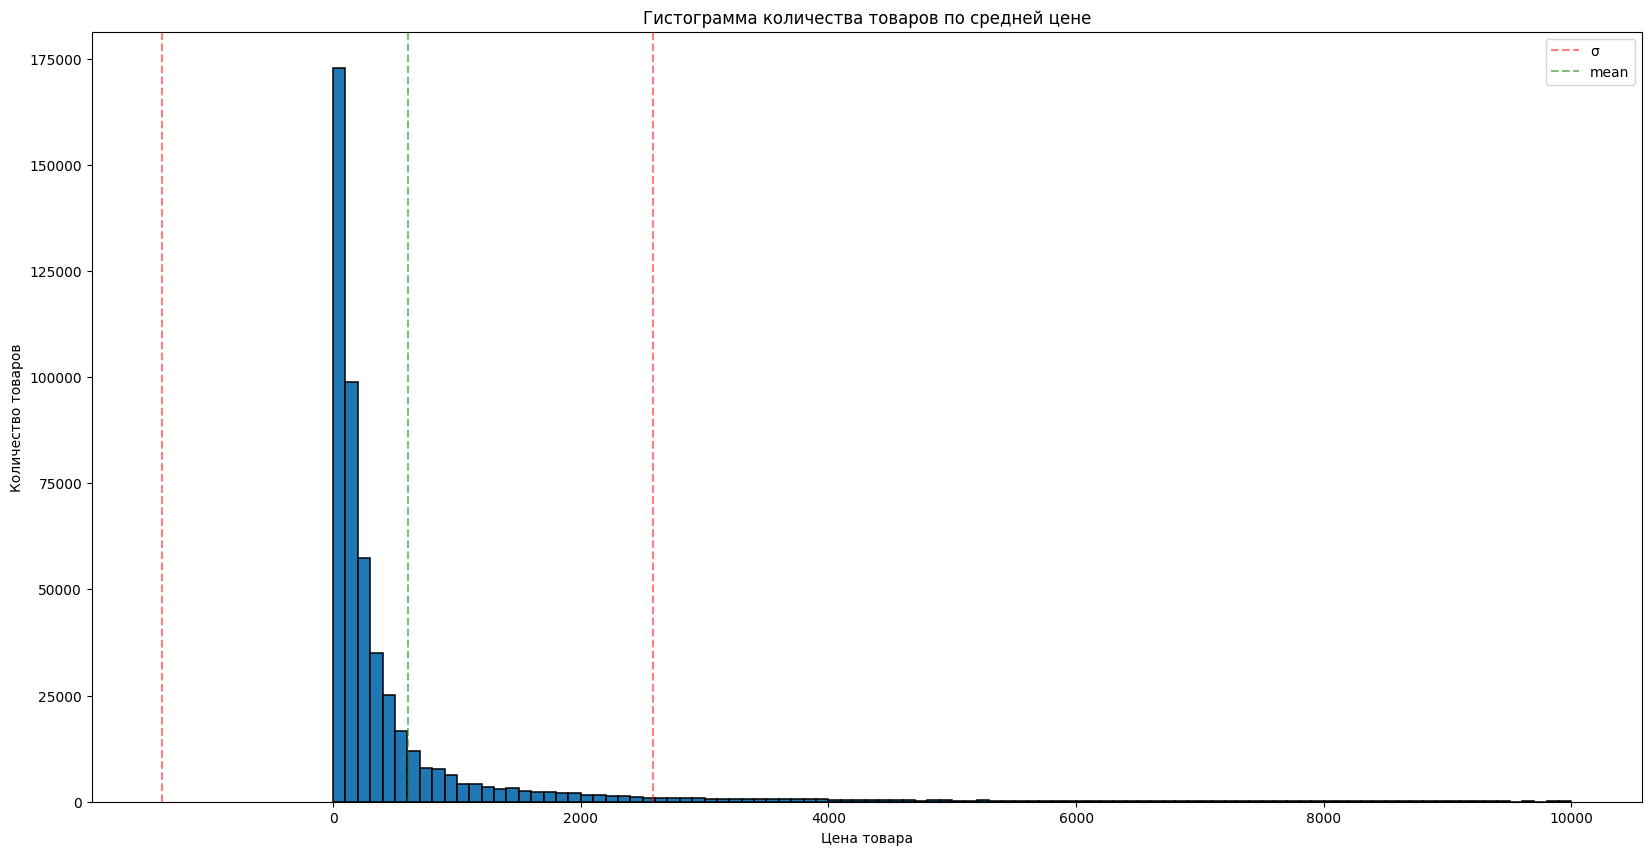

In [35]:
scatter_hist_of_products(data, nbins=100, price_limit=(0, 10_000))

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


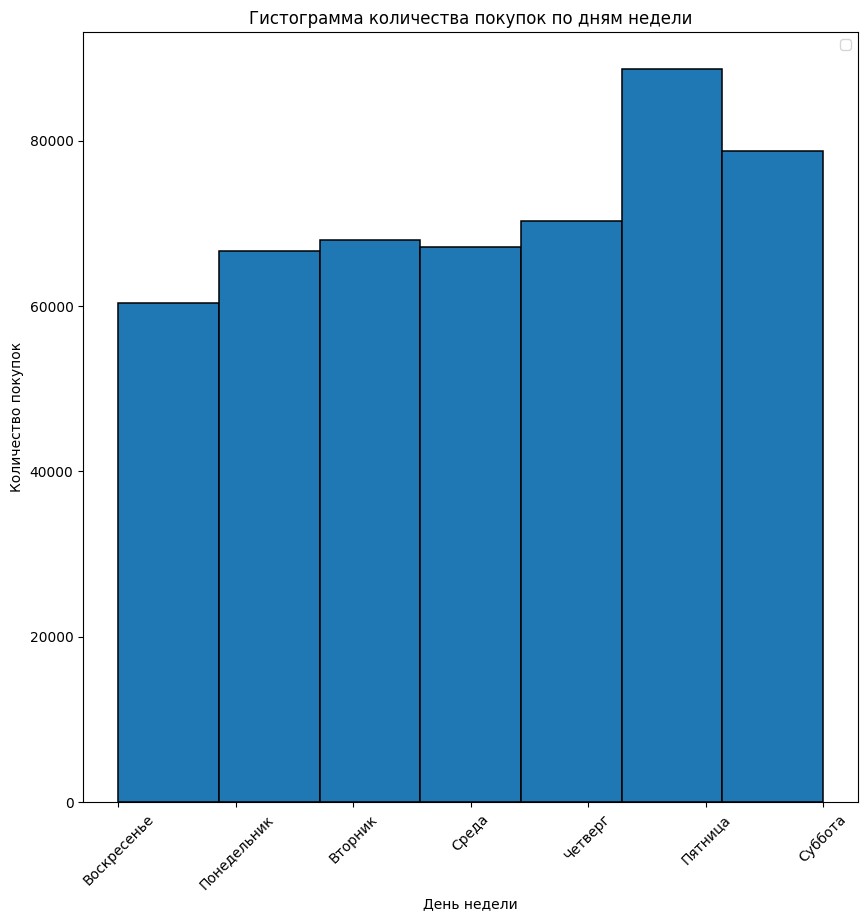

In [49]:
scatter_hist_of_weekdays(data)

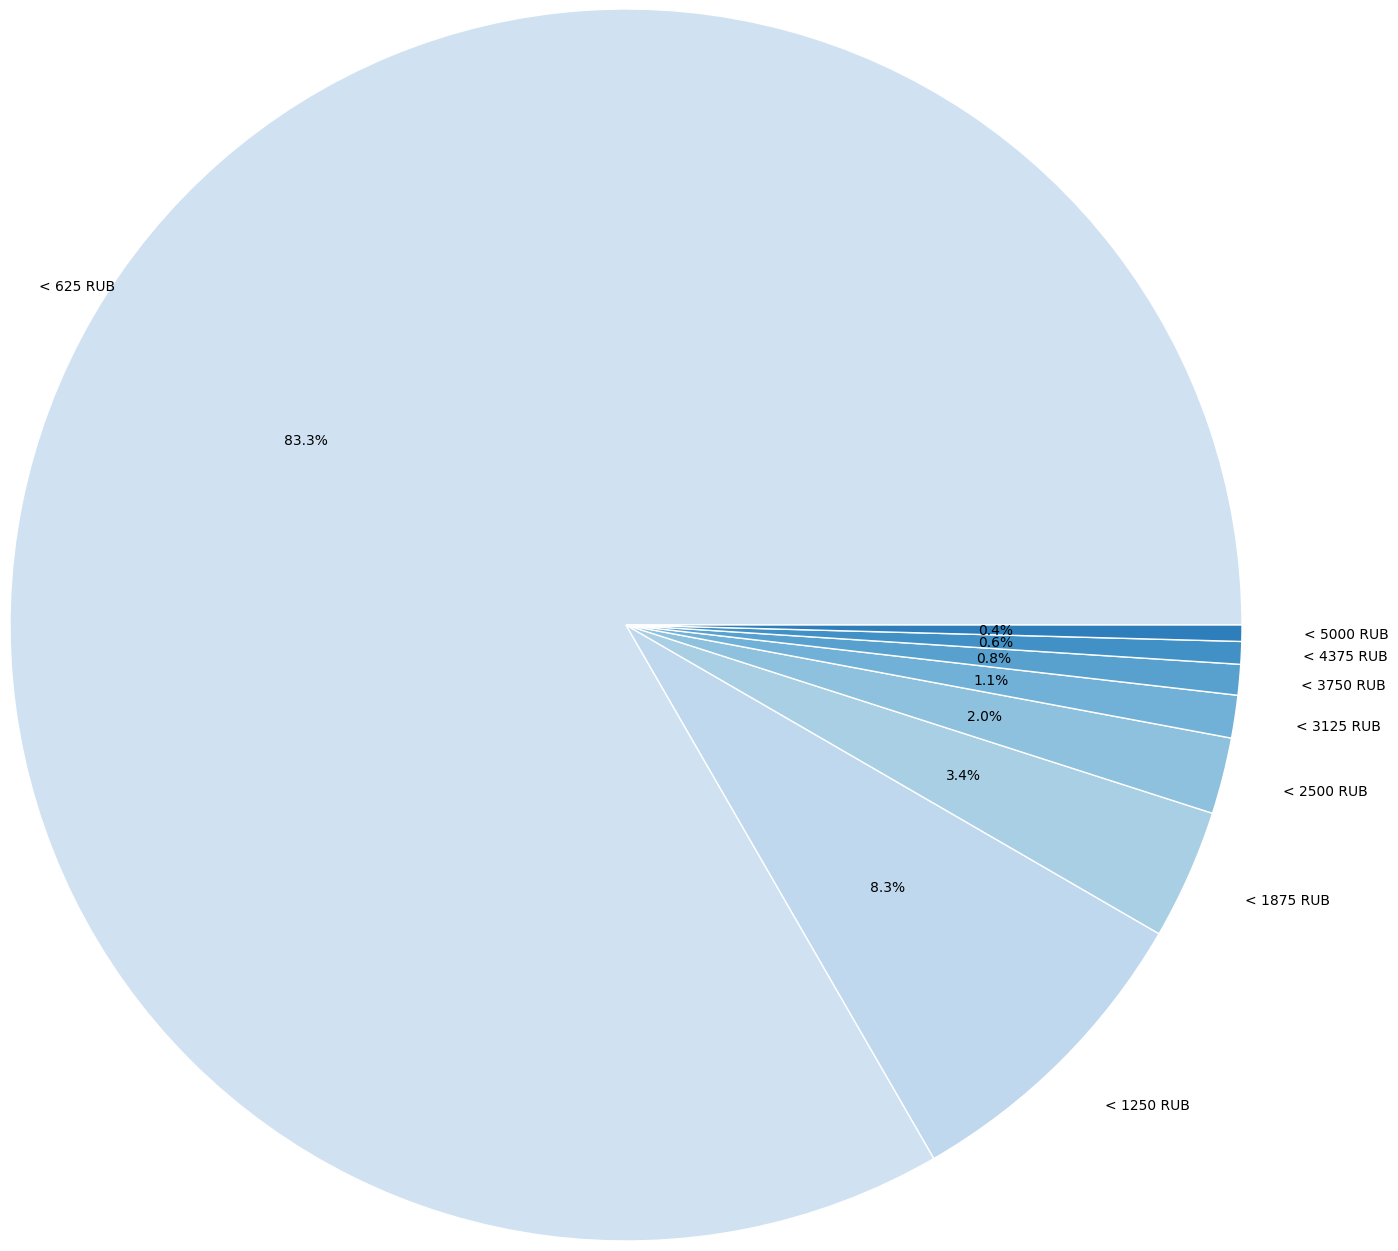

In [37]:
scatter_pie_of_prices(data, nbins=8, top_limit=5_000)

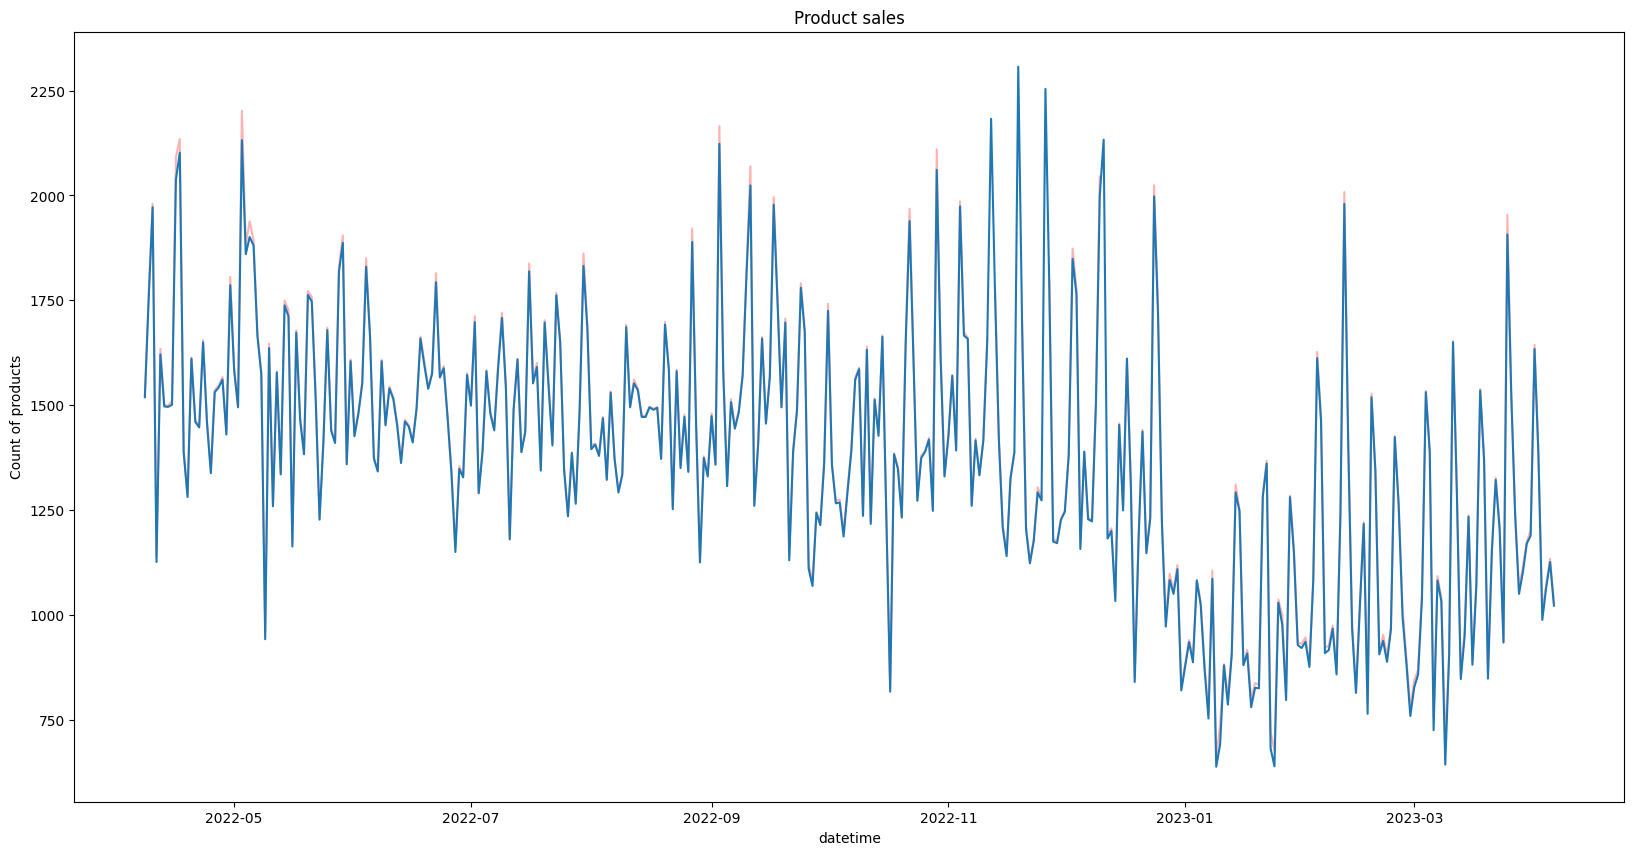

In [38]:
plot_over_time(data)

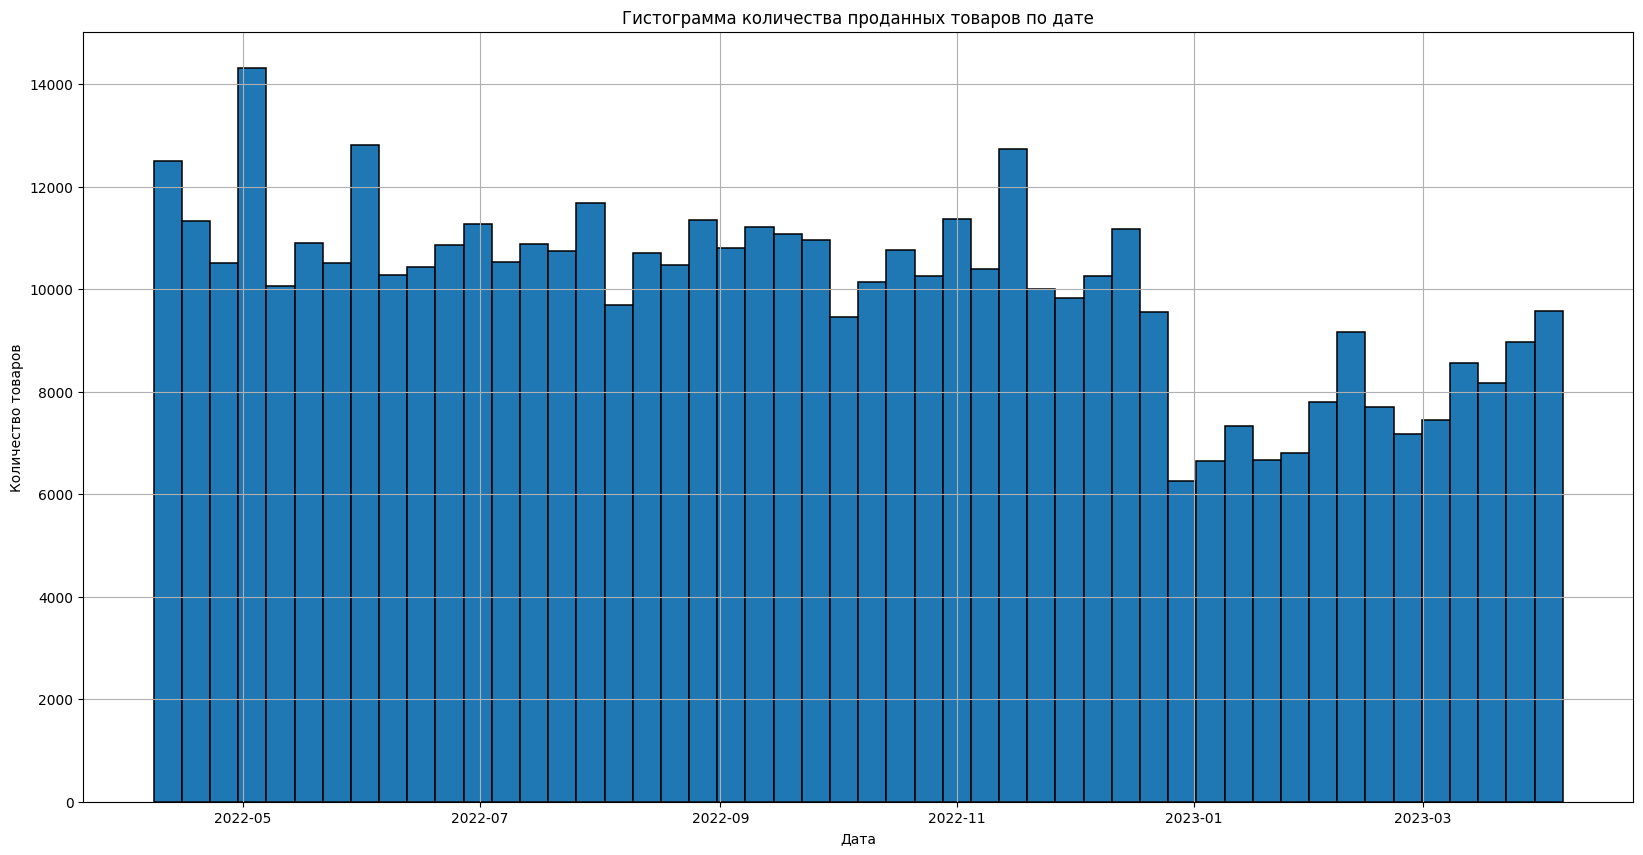

In [47]:
scatter_hist_over_time(data, nbins=50, plot_ma=False)

### Прогнозирование

In [ ]:
# purchases = get_user_purchases(data, batch_size=100_000)
# purchases

In [ ]:
# three_sigmas(purchases)

### Временные ряды

In [ ]:
class Period:
    def __init__(self, date_from, date_to, date_type='%d.%m.%y'):
        self.start = datetime.strptime(date_from, date_type)
        self.end = datetime.strptime(date_to, date_type)

    def is_in(self, date):
        return self.start <= date <= self.end

    def includes(self, data):
        return data.loc[data.datetime >= self.start].loc[data.datetime <= self.end]

In [ ]:
# def get_from_to(data, date_from, date_to, date_type='%d/%m/%y'):
#     return data.loc[data.datetime >= datetime.strptime(date_from, date_type)].loc[data.datetime <= datetime.strptime(date_to, date_type)]

def get_from_to(data, date_period):
    return date_period.includes(data)

def get_by_weekday(data, weekday):
    i = 0
    for ind in weekday_dict:
        if weekday == weekday_dict[ind]:
            i = ind
    return data.loc[data.weekday == i]

def sort_by_date(data):
    return data.sort_values(by=['datetime'])


# sort_by_date(get_from_to(data, '01.04.22', '20.12.22', '%d.%m.%y'))
# get_by_weekday(data, 'Четверг')

In [ ]:

# sort_by_date(get_from_to(data, Period('01.04.22', '20.12.22', '%d.%m.%y')))

### Эластичность спроса по цене

In [ ]:
def get_elasticity_over_periods(data, product_id, date_period_1, date_period_2):
    data = data[['product_id', 'line_item_price', 'datetime']].loc[data.product_id == product_id]

    data_1 = date_period_1.includes(data)
    data_2 = date_period_2.includes(data)

    count_1 = data_1.shape[0]
    count_2 = data_2.shape[0]

    price_1 = data_1['line_item_price'].mean()
    price_2 = data_2['line_item_price'].mean()

    e = ((count_2 - count_1) / count_1) / ((price_2 - price_1) / price_1)
    return e

In [ ]:
def get_dates_when_price_changed(data, product_id):
    data = data[['product_id', 'line_item_price', 'datetime']].loc[data.product_id == product_id]
    when_changed = data['line_item_price'].shift() != data['line_item_price']#['datetime']
    return when_changed

In [ ]:
# get_elasticity_over_periods(data, 18785635, Period('19.10.21', '20.12.22'), Period('20.12.22', '22.12.23'))

In [ ]:
# get_dates_when_price_changed(data, 18785635)

In [ ]:
import pandas_profiling
# prof = data.profile_report(progress_bar=True, explorative=True)

In [ ]:
# prof = pandas_profiling.ProfileReport(data)
# prof.to_file(output_file='out/output.html')